# Subscription Based Business Model

MRR (Monthly Recurring Revenue) is one of the most important metrics for subscription based business models. <br>
The nature of the recurring payments allows future revenue to be easily tracked and forecasted.<br>
Stakeholders in the company need to have a clear view of business metrics and understand what drivers affect profitability so that decisions can be quickly made to increase sales and reduce churn.

**This notebook will visualize the MRR to understand the problem and then attempt to understand why users churn using simple logistic regression.**


Notes:
  - The data below is from Kaggle and includes 1 month of telecom data.
  - Artificially created random growth in transactions over 12 months for this simulation.
  - Subscription upgrades and downgrades are not available in this dataset.

Churning is one of the main opposing factors that subscription-based businesses face. Business models that depend on the growth of net MRR (monthly recurring revenue) to prosper need to understand why customers cancel or downgrade their subscriptions so that actions can be taken to keep that net MRR from dropping.


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

## 1. Setting up the Dataset

In [0]:
telco_data = pd.read_csv('https://raw.githubusercontent.com/Mushtatoes/telecom-business/master/telco_data.csv')

Since we only have one months worth of telecom data, we will split the data into months over the year and simulate artificial growth here.

In [0]:
# Create arbitrary monthly growth probabilities here:
mprob = {1: 0.03, 2: 0.04, 3: 0.05, 4: 0.06, 5: 0.07, 6: 0.08, 7: 0.09, 8: 0.10, 9: 0.11, 10: 0.115, 11: 0.12, 12: 0.135}
mprob_key = list(mprob.keys())
mprob_val = list(mprob.values())

In [4]:
# Assign month column using transaction probabilities:
telco_df = pd.DataFrame(telco_data).reset_index()

np.random.seed(44)

telco_df['Month'] = [np.random.choice(mprob_key, p = mprob_val) for row in telco_df.index]

telco_df.drop('index', axis = 1, inplace = True)

telco_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Month
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,11
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No,3
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,10
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,7
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,7


In [5]:
# Adding MRR Column based on monthly charge and if customer churned:
telco_df['MRR'] = telco_df['MonthlyCharges'].where(telco_df['Churn'] == 'No', 0)

telco_df['ChurnMRR'] = telco_df['MonthlyCharges'].where(telco_df['Churn'] == 'Yes', 0)

telco_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Month,MRR,ChurnMRR
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,11,29.85,0.00
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No,3,56.95,0.00
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,10,0.00,53.85
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,7,42.30,0.00
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,7,0.00,70.70


In [6]:
# Group by to get monthly revenue by Month
monthly_rev_df = telco_df.groupby('Month').sum().reset_index()

monthly_rev_df = monthly_rev_df[['Month', 'MRR', 'ChurnMRR']]

# Calculate NetMRR and Growth Rate

monthly_rev_df['NetMRR'] = monthly_rev_df['MRR'] - monthly_rev_df['ChurnMRR']

monthly_rev_df['GrowthRate'] = monthly_rev_df['NetMRR'].diff()/ monthly_rev_df['NetMRR']

monthly_rev_df

,Month,MRR,ChurnMRR,NetMRR,GrowthRate
0,1,7544.75,3866.10,3678.65,NaN
1,2,13015.80,5805.00,7210.80,0.489842
2,3,15850.55,7334.90,8515.65,0.153230
3,4,19485.30,8442.65,11042.65,0.228840
4,5,22628.85,9808.70,12820.15,0.138649
5,6,25086.65,12229.80,12856.85,0.002855
6,7,30384.40,13463.35,16921.05,0.240186
7,8,30141.55,12992.40,17149.15,0.013301
8,9,33904.30,13327.90,20576.40,0.166562
9,10,35781.20,16058.05,19723.15,-0.043261


## 2. Visualizing MRR

**Net MRR and MRR Growth Rate**

Net MRR will show how much recurring revenue will come in after upgrades, downgrades, new customers, and churned customers are taken into account.

MRR Growth Rate will compare the growth of the current month versus the growth of the prior month.Keeping this number positive is essential for a business that wants to grow.

Below is a visual of these metrics for a growing telecom company:

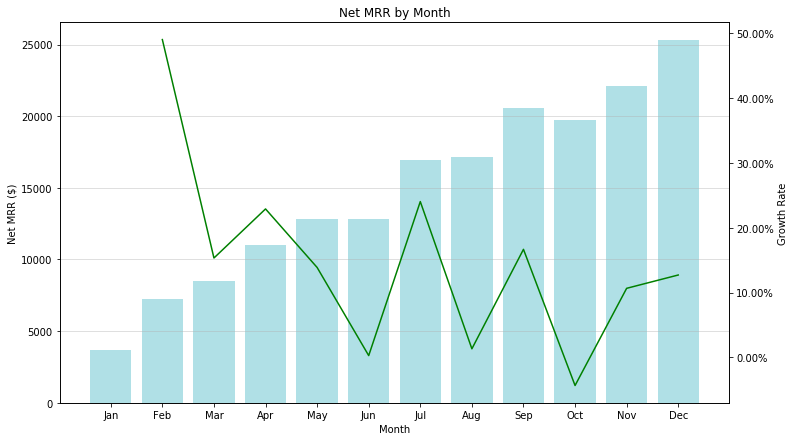

In [7]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
x = monthly_rev_df.Month
net_mrr = monthly_rev_df.NetMRR
growth = monthly_rev_df.GrowthRate

plt.figure(figsize = (12,7))

plt.bar(x, net_mrr, color = 'powderblue')

plt.xticks(x, months)
plt.xlabel('Month')
plt.ylabel('Net MRR ($)')
plt.title('Net MRR by Month')
plt.grid(axis = 'y', alpha = 0.5)

growth_line = plt.twinx()
growth_line.plot(x, growth, color = 'green')
growth_line.set_ylabel('Growth Rate')

#Format to percentage
growth_yticks = growth_line.get_yticks()
growth_line.set_yticklabels(['{:,.2%}'.format(x) for x in growth_yticks])

plt.show()

January has a growth rate of 1.00 that is not shown here because the company's life began during that month.

This graph shows the raw amount of recurring revenue that's going to be obtained in the future and the growth over the prior month.

> Since this is actually data from a single month, the MRR from previous months do not carry over to the next month. Therefore, this is a representation of MRR Growth per month, rather than total MRR including existing customers.

Let's take a look at the amount of churning that's occuring behind the Net MRR.


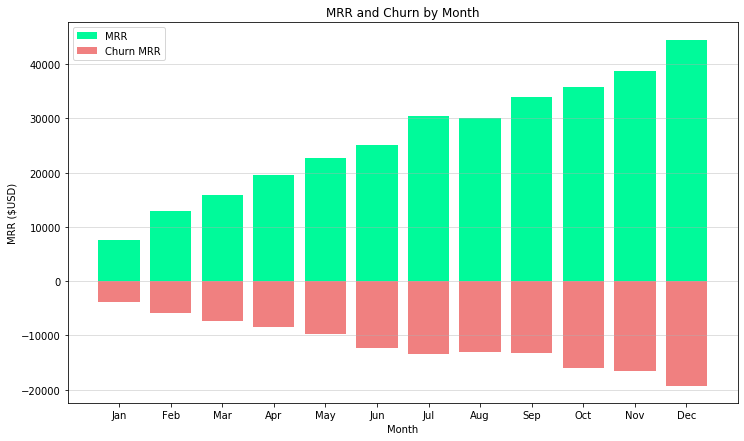

In [8]:
mrr_rev = monthly_rev_df.MRR
churn_rev = monthly_rev_df.ChurnMRR

plt.figure(figsize = (12,7))
p1 = plt.bar(x, mrr_rev, color = 'mediumspringgreen')
p2 = plt.bar(x, -churn_rev, color = 'lightcoral')

plt.xticks(x, months)
plt.xlabel('Month')
plt.ylabel('MRR ($USD)')
plt.title('MRR and Churn by Month')
plt.grid(axis = 'y', alpha = 0.5)

plt.legend(['MRR','Churn MRR'])

plt.show()

We can clearly see that due to churning, a good chunk of monthly recurring revenue is lost.

We will try to use the available columns in the given dataset to see if we can understand what is making customers churn.

> Similar situation here, since each month represents a unique customer, churned customers are actually already existing customers that have cancelled their subscriptions. Any positive values represent new customer growth and there are no existing customers, even from months prior.

## 3. Data Preparation and Cleaning

Before using the data for any calculations, the raw data needs to be analyzed, cleansed, and prepared.

In [9]:
# Checking for missing data
telco_df[telco_df.isnull() == True].count()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
Month               0
MRR                 0
ChurnMRR            0
dtype: int64

Creating new dataframe to hold variables that are going to be used in regression analysis. <br>

In [0]:
# Dropping customerID because it is not required and removing calculated columns.
log_df = telco_df.drop(['customerID', 'Month', 'MRR', 'ChurnMRR'], axis = 1)

To use the correlation matrix provided by pandas and perform logistic regression, we need to have only numeric data type features.

Now, we will identify non-numeric data types and convert to dummy variables if required.

In [11]:
# Taking a look at the data types
log_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), object(17)
memory usage: 1.1+ MB


In [0]:
# Total Charges object instead of float, there are spaces in empty total charges that need to be replaced
log_df['TotalCharges'].replace(' ', 0, inplace = True)
log_df['TotalCharges'] = pd.to_numeric(log_df['TotalCharges'])

In [13]:
# Converting any object data types into dummy variables to use in correlation matrix
for col in log_df:
  if log_df[col].dtype == np.object:
    log_df = pd.get_dummies(log_df, columns = [col], prefix = col)

log_df

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_No,Churn_Yes
0,0,1,29.85,29.85,1,0,0,1,1,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0
1,0,34,56.95,1889.50,0,1,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1,1,0
2,0,2,53.85,108.15,0,1,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,1
3,0,45,42.30,1840.75,0,1,1,0,1,0,1,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,1,0,1,0,0,0,1,0
4,0,2,70.70,151.65,1,0,1,0,1,0,0,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,24,84.80,1990.50,0,1,0,1,0,1,0,1,0,0,1,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,1,1,0
7039,0,72,103.20,7362.90,1,0,0,1,0,1,0,1,0,0,1,0,1,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,1,0,0,1,0
7040,0,11,29.60,346.45,1,0,0,1,0,1,1,0,0,1,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0
7041,1,4,74.40,306.60,0,1,0,1,1,0,0,1,0,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,1


## 4. Feature Selection and Regression Analysis

Using a correlation matrix, we will take a look at the correlation coefficient between each feature and a customer's decision to churn.

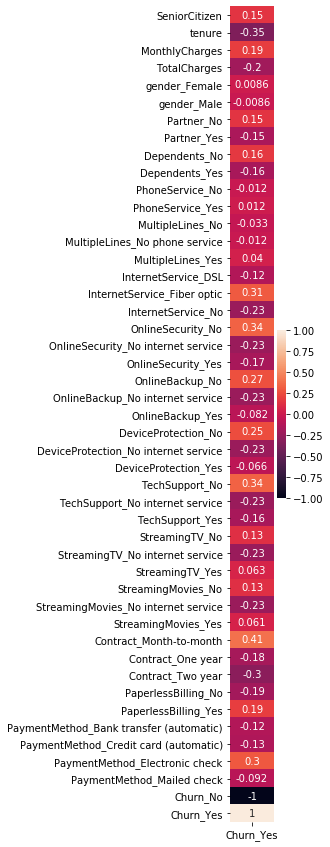

In [14]:
corr_matrix = log_df.corr()[['Churn_Yes']]

plt.figure(figsize = (1,15))
sns.heatmap(corr_matrix, annot = True)

plt.show()

Many of the features have a small correlation coefficient, so we will weed out the most important features and use them for logistic regression.

In [15]:
# We use r of 0.3 required to pass feature into logistic regression model
reg_cols = corr_matrix[abs(corr_matrix.Churn_Yes) > 0.3]
reg_cols.reset_index()

,index,Churn_Yes
0,tenure,-0.352229
1,InternetService_Fiber optic,0.308020
2,OnlineSecurity_No,0.342637
3,TechSupport_No,0.337281
4,Contract_Month-to-month,0.405103
5,Contract_Two year,-0.302253
6,PaymentMethod_Electronic check,0.301919
7,Churn_No,-1.000000
8,Churn_Yes,1.000000


In [16]:
# Using above variables to train and test data; drop churn rows
X = log_df[reg_cols.index.values].drop(['Churn_No', 'Churn_Yes'], axis = 1)
y = log_df['Churn_Yes']

# Split randomly into training and test sets, train size 70%, test size 30%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

model = LogisticRegression()
result = model.fit(X_train, y_train)

model_prediction = model.predict(X_test)

metrics.accuracy_score(y_test, model_prediction)

0.807382867960246

**Accuracy Score : 80.74%**

Using the most impactful variables chosen from the use of a correlation matrix, we are able to achieve an 80.74% accuracy score on the test set.

Not a bad accuracy score. Too low would mean our model was not working well on predicting customer churn, too high could indicate overfitting. More testing would be required, but this gives an idea on where business suggestions could be made and confidence in those suggestions.

## 5. Conclusion and Business Analysis

[]

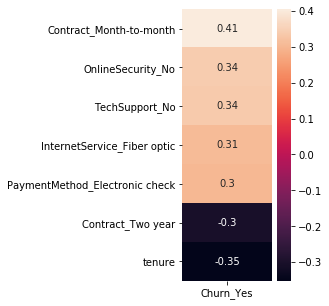

In [17]:
# Ordered Correlation Matrix to see features clearly
plt.figure(figsize = (2,5))

coeff = reg_cols.drop(['Churn_No', 'Churn_Yes']).sort_values('Churn_Yes', ascending = False)
sns.heatmap(coeff, annot = True)

plt.plot()

####Business Analysis

**Highest Churn: Contract_Month-to-month**

Monthly contracts have the highest correlation to churning over all the available variables in the dataset. This naturally makes sense, customers who are not contractually bound can cancel their subscription at any time. Based on this information, a salesman's priority would be to try to get customers to sign a long-term contract.

**Lowest Churn: Tenure**

The longer a customer has been with the company, the more likely they will stay. This is an indication that the customer is satisfied and trust the company. 

#### Conclusion
Being able to clearly see monthly recurring revenue will lead to better forecasting processes and business decisions. Managers need to be able to inform the sales team on what should be focused on to maximize net MRR. Collecting the right data is key to understanding when and why customers will churn. Then using that data, we can obtain statistical proof on what business decisions need to be made. 

After more testing and active monitoring on decisions made through analysis like this, more improvements can be made to the model. Confident business decisions based on the data can eventually be made and we can see the business prosper! 